In [1]:
!wget http://www.soshnikov.com/permanent/data/petfaces.tar.gz
!tar xfz petfaces.tar.gz
!rm petfaces.tar.gz

--2023-05-20 16:45:47--  http://www.soshnikov.com/permanent/data/petfaces.tar.gz
Resolving www.soshnikov.com (www.soshnikov.com)... 79.137.227.122
Connecting to www.soshnikov.com (www.soshnikov.com)|79.137.227.122|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24483412 (23M) [application/x-tar]
Saving to: ‘petfaces.tar.gz’

petfaces.tar.gz     100%[===================>]  23.35M   260KB/s    in 93s     

2023-05-20 16:47:21 (258 KB/s) - ‘petfaces.tar.gz’ saved [24483412/24483412]



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as tr
from sklearn.metrics import confusion_matrix
import os
from PIL import Image
import seaborn as sn
from sklearn.metrics import confusion_matrix

try:
    from torchinfo import summary
except:
    !pip install torchinfo
    from torchinfo import summary


def display_images(l,titles=None,fontsize=12):
    n=len(l)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
        if titles is not None:
            ax[i].set_title(titles[i],fontsize=fontsize)
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
number_classes = len(os.listdir('petfaces'))
print("Количество классов:", number_classes)

Количество классов: 35


Сделаем все фотографии размером 128x128

In [5]:
image_size = 128
batch_size = 64

In [6]:
import PIL

try:
    from imgaug import augmenters as iaa
    import imgaug as ia
except:
    !pip install git+https://github.com/aleju/imgaug
    from imgaug import augmenters as iaa
    import imgaug as ia

class ImgAugTransform:
  def __init__(self):
    self.aug = iaa.Sequential([
        iaa.Resize((128, 128)),
        iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
        iaa.Fliplr(0.5),
        iaa.Affine(rotate=(-20, 20), mode='symmetric'),
        iaa.Sometimes(0.25,
                      iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                 iaa.CoarseDropout(0.1, size_percent=0.5)])),
        iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
    ])
      
  def __call__(self, img):
    img = np.array(img)
    return self.aug.augment_image(img)

dataset = torchvision.datasets.ImageFolder(
    'petfaces',
    transform = tr.Compose([
        tr.Resize(image_size),
        tr.CenterCrop(image_size),
        tr.RandomHorizontalFlip(),
        tr.RandomRotation(20),
        tr.ColorJitter(hue=.05, saturation=.05),
        ImgAugTransform(),
        tr.ToTensor()
    ]))

pet_classes_names = dataset.classes

# train test split
len_dataset = len(dataset)
train_length = int(0.8 * len_dataset)

train_data, test_data = torch.utils.data.random_split(dataset, [train_length, len_dataset-train_length])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

Выведем примеры из датасета, с которыми будет происходить работа.

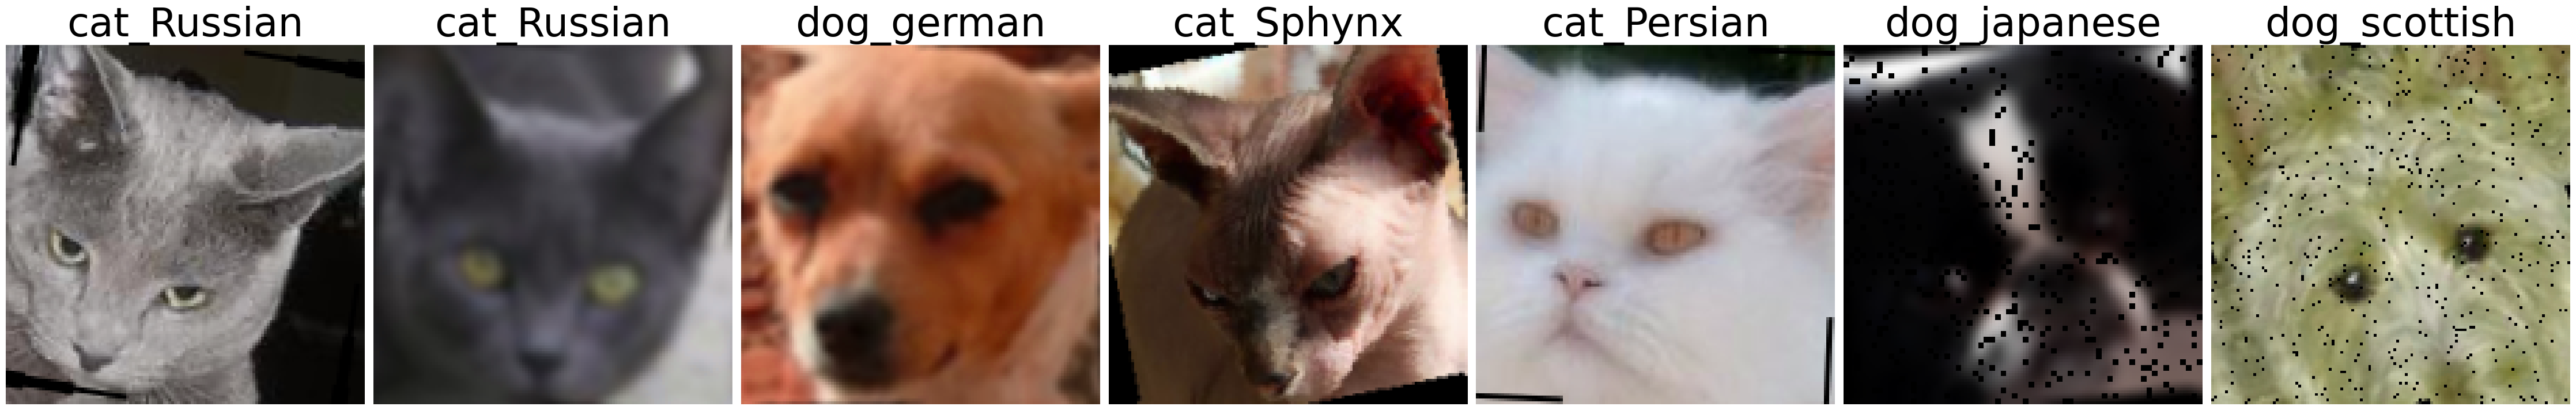

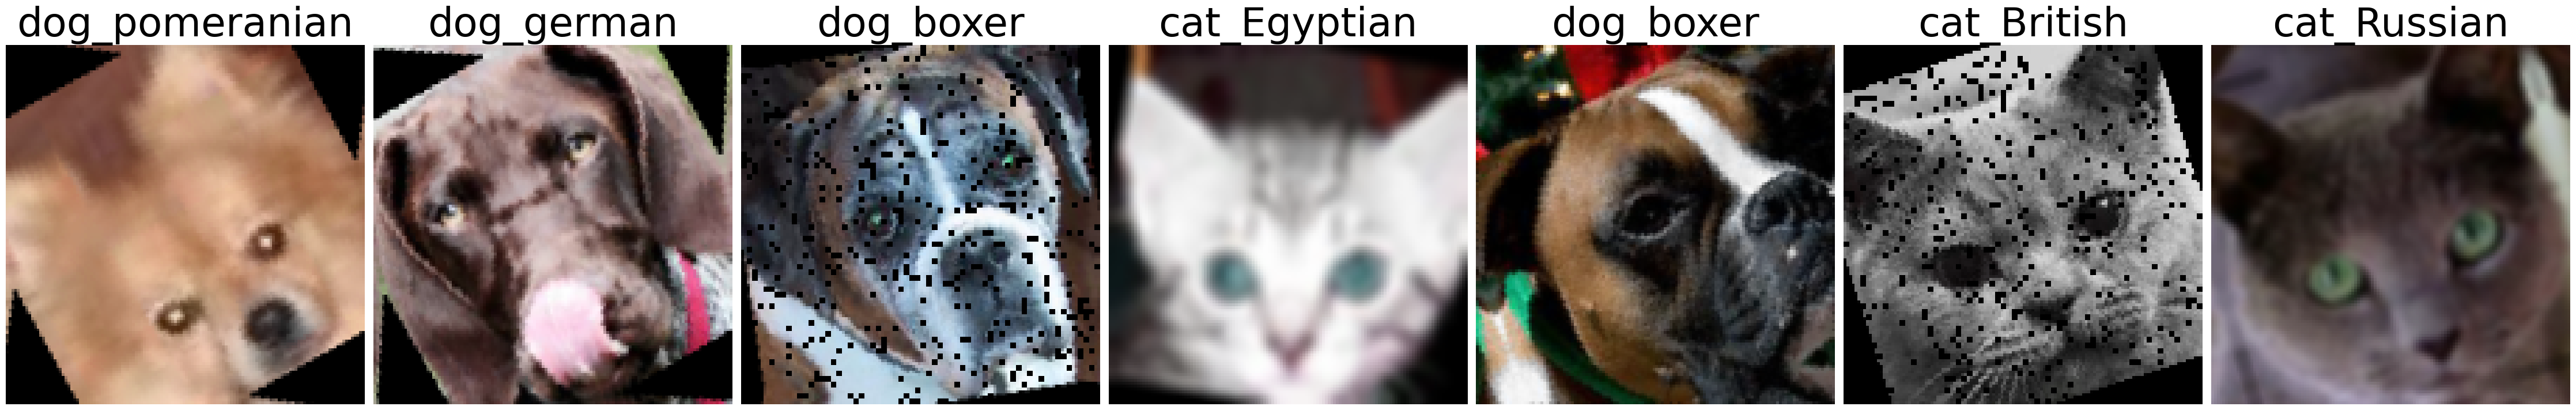

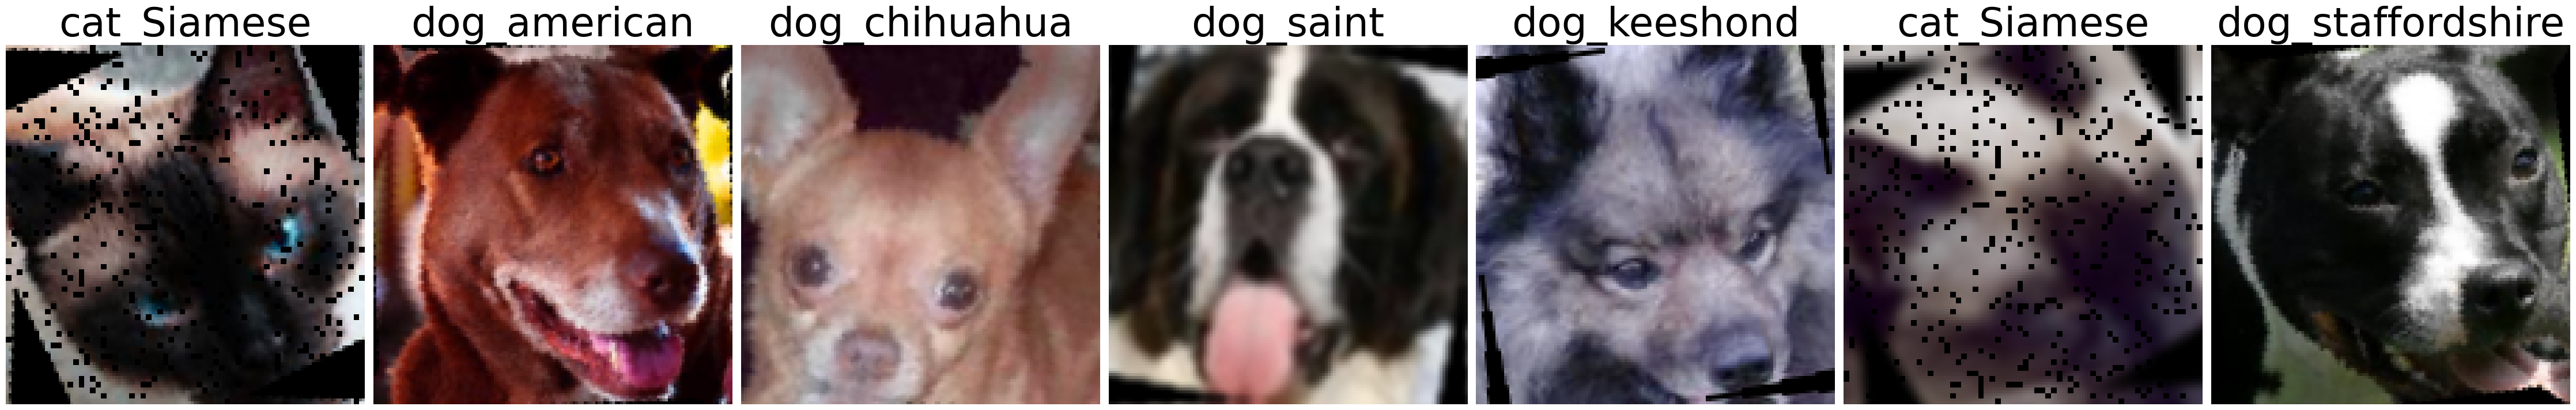

In [7]:
for _,(i,l) in zip(range(3),train_loader):
    display_images(i[:7].permute(0,2,3,1),titles=[dataset.classes[x] for x in l[:7]],fontsize=50)

In [8]:
from sklearn.metrics import confusion_matrix

In [9]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(3,16,(3,3)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(16,32,(3,3)),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(32,64,(3,3)),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.MaxPool2d(2),

    torch.nn.Conv2d(64,128,(3,3)),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.MaxPool2d(2),

    torch.nn.Flatten(),
    torch.nn.Linear(4608,2048),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(2048,number_classes)
)
summary(model)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Conv2d: 1-1                            448
├─ReLU: 1-2                              --
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            4,640
├─ReLU: 1-5                              --
├─Dropout: 1-6                           --
├─MaxPool2d: 1-7                         --
├─Conv2d: 1-8                            18,496
├─ReLU: 1-9                              --
├─Dropout: 1-10                          --
├─MaxPool2d: 1-11                        --
├─Conv2d: 1-12                           73,856
├─ReLU: 1-13                             --
├─Dropout: 1-14                          --
├─MaxPool2d: 1-15                        --
├─Flatten: 1-16                          --
├─Linear: 1-17                           9,439,232
├─ReLU: 1-18                             --
├─Dropout: 1-19                          --
├─Linear: 1-20                           71,715
Tota

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

Обучение нейронной сети

In [11]:
def train_epoch(net,dataloader,lr=0.01,optimizer=None,loss_fn = torch.nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    net.train()
    total_loss,acc,count = 0,0,0
    for features,labels in dataloader:
        f = features.to(device)
        l = labels.to(device)
        optimizer.zero_grad()
        out = net(f)
        loss = loss_fn(out,l)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        _,predicted = torch.max(out,1)
        acc+=(predicted==l).sum()
        count+=len(labels)
    return total_loss.item()/count, acc.item()/count

def validate(net, dataloader,loss_fn=torch.nn.NLLLoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            f = features.to(device)
            l = labels.to(device)
            out = net(f)
            loss += loss_fn(out,l) 
            pred = torch.max(out,1)[1]
            acc += (pred==l).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

def train(net,train_loader,test_loader,optimizer=None,lr=0.01,epochs=10,loss_fn=torch.nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for epoch in range(epochs):
        tl,ta = train_epoch(net,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn)
        vl,va = validate(net,test_loader,loss_fn=loss_fn)
        print(f"Epoch {epoch:2}: Train accuracy={ta:.3f} | Val accuracy={va:.3f} | Train loss={tl:.3f} | Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

hist = train(model,train_loader,test_loader,epochs=100,lr=0.001,loss_fn=torch.nn.CrossEntropyLoss())

Epoch  0: Train accuracy=0.068 | Val accuracy=0.115 | Train loss=0.054 | Val loss=0.059
Epoch  1: Train accuracy=0.130 | Val accuracy=0.121 | Train loss=0.050 | Val loss=0.057
Epoch  2: Train accuracy=0.179 | Val accuracy=0.218 | Train loss=0.046 | Val loss=0.056
Epoch  3: Train accuracy=0.259 | Val accuracy=0.283 | Train loss=0.041 | Val loss=0.054
Epoch  4: Train accuracy=0.310 | Val accuracy=0.305 | Train loss=0.038 | Val loss=0.053
Epoch  5: Train accuracy=0.324 | Val accuracy=0.285 | Train loss=0.037 | Val loss=0.053
Epoch  6: Train accuracy=0.371 | Val accuracy=0.359 | Train loss=0.034 | Val loss=0.050
Epoch  7: Train accuracy=0.389 | Val accuracy=0.369 | Train loss=0.033 | Val loss=0.048
Epoch  8: Train accuracy=0.419 | Val accuracy=0.411 | Train loss=0.032 | Val loss=0.049
Epoch  9: Train accuracy=0.459 | Val accuracy=0.395 | Train loss=0.029 | Val loss=0.047
Epoch 10: Train accuracy=0.475 | Val accuracy=0.381 | Train loss=0.029 | Val loss=0.047
Epoch 11: Train accuracy=0.484 |

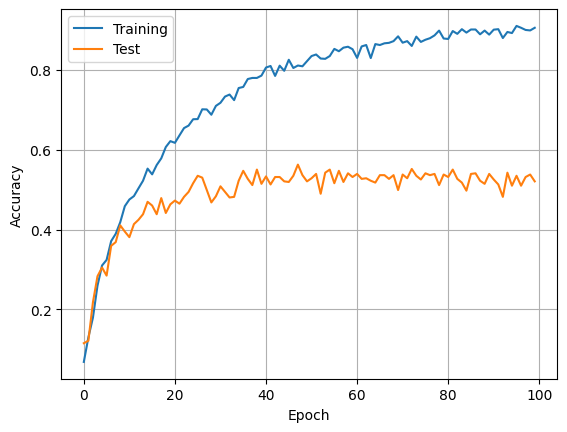

In [12]:
plt.plot(hist['train_acc'],label='Training')
plt.plot(hist['val_acc'],label='Test')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Вывод Confusion Matrix

In [22]:
def show_confusion_matrix(net, test_loader):
  y_pred = []
  y_true = []

  # Проходим по тестовым данным
  for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          output = net(inputs) # Наполняем сеть

          output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
          y_pred.extend(output)
          
          labels = labels.data.cpu().numpy()
          y_true.extend(labels)

  classes = test_loader.dataset.dataset.classes
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                      columns = [i for i in classes])
  plt.figure(figsize = (25,20))
  sn.heatmap(df_cm, annot=True)

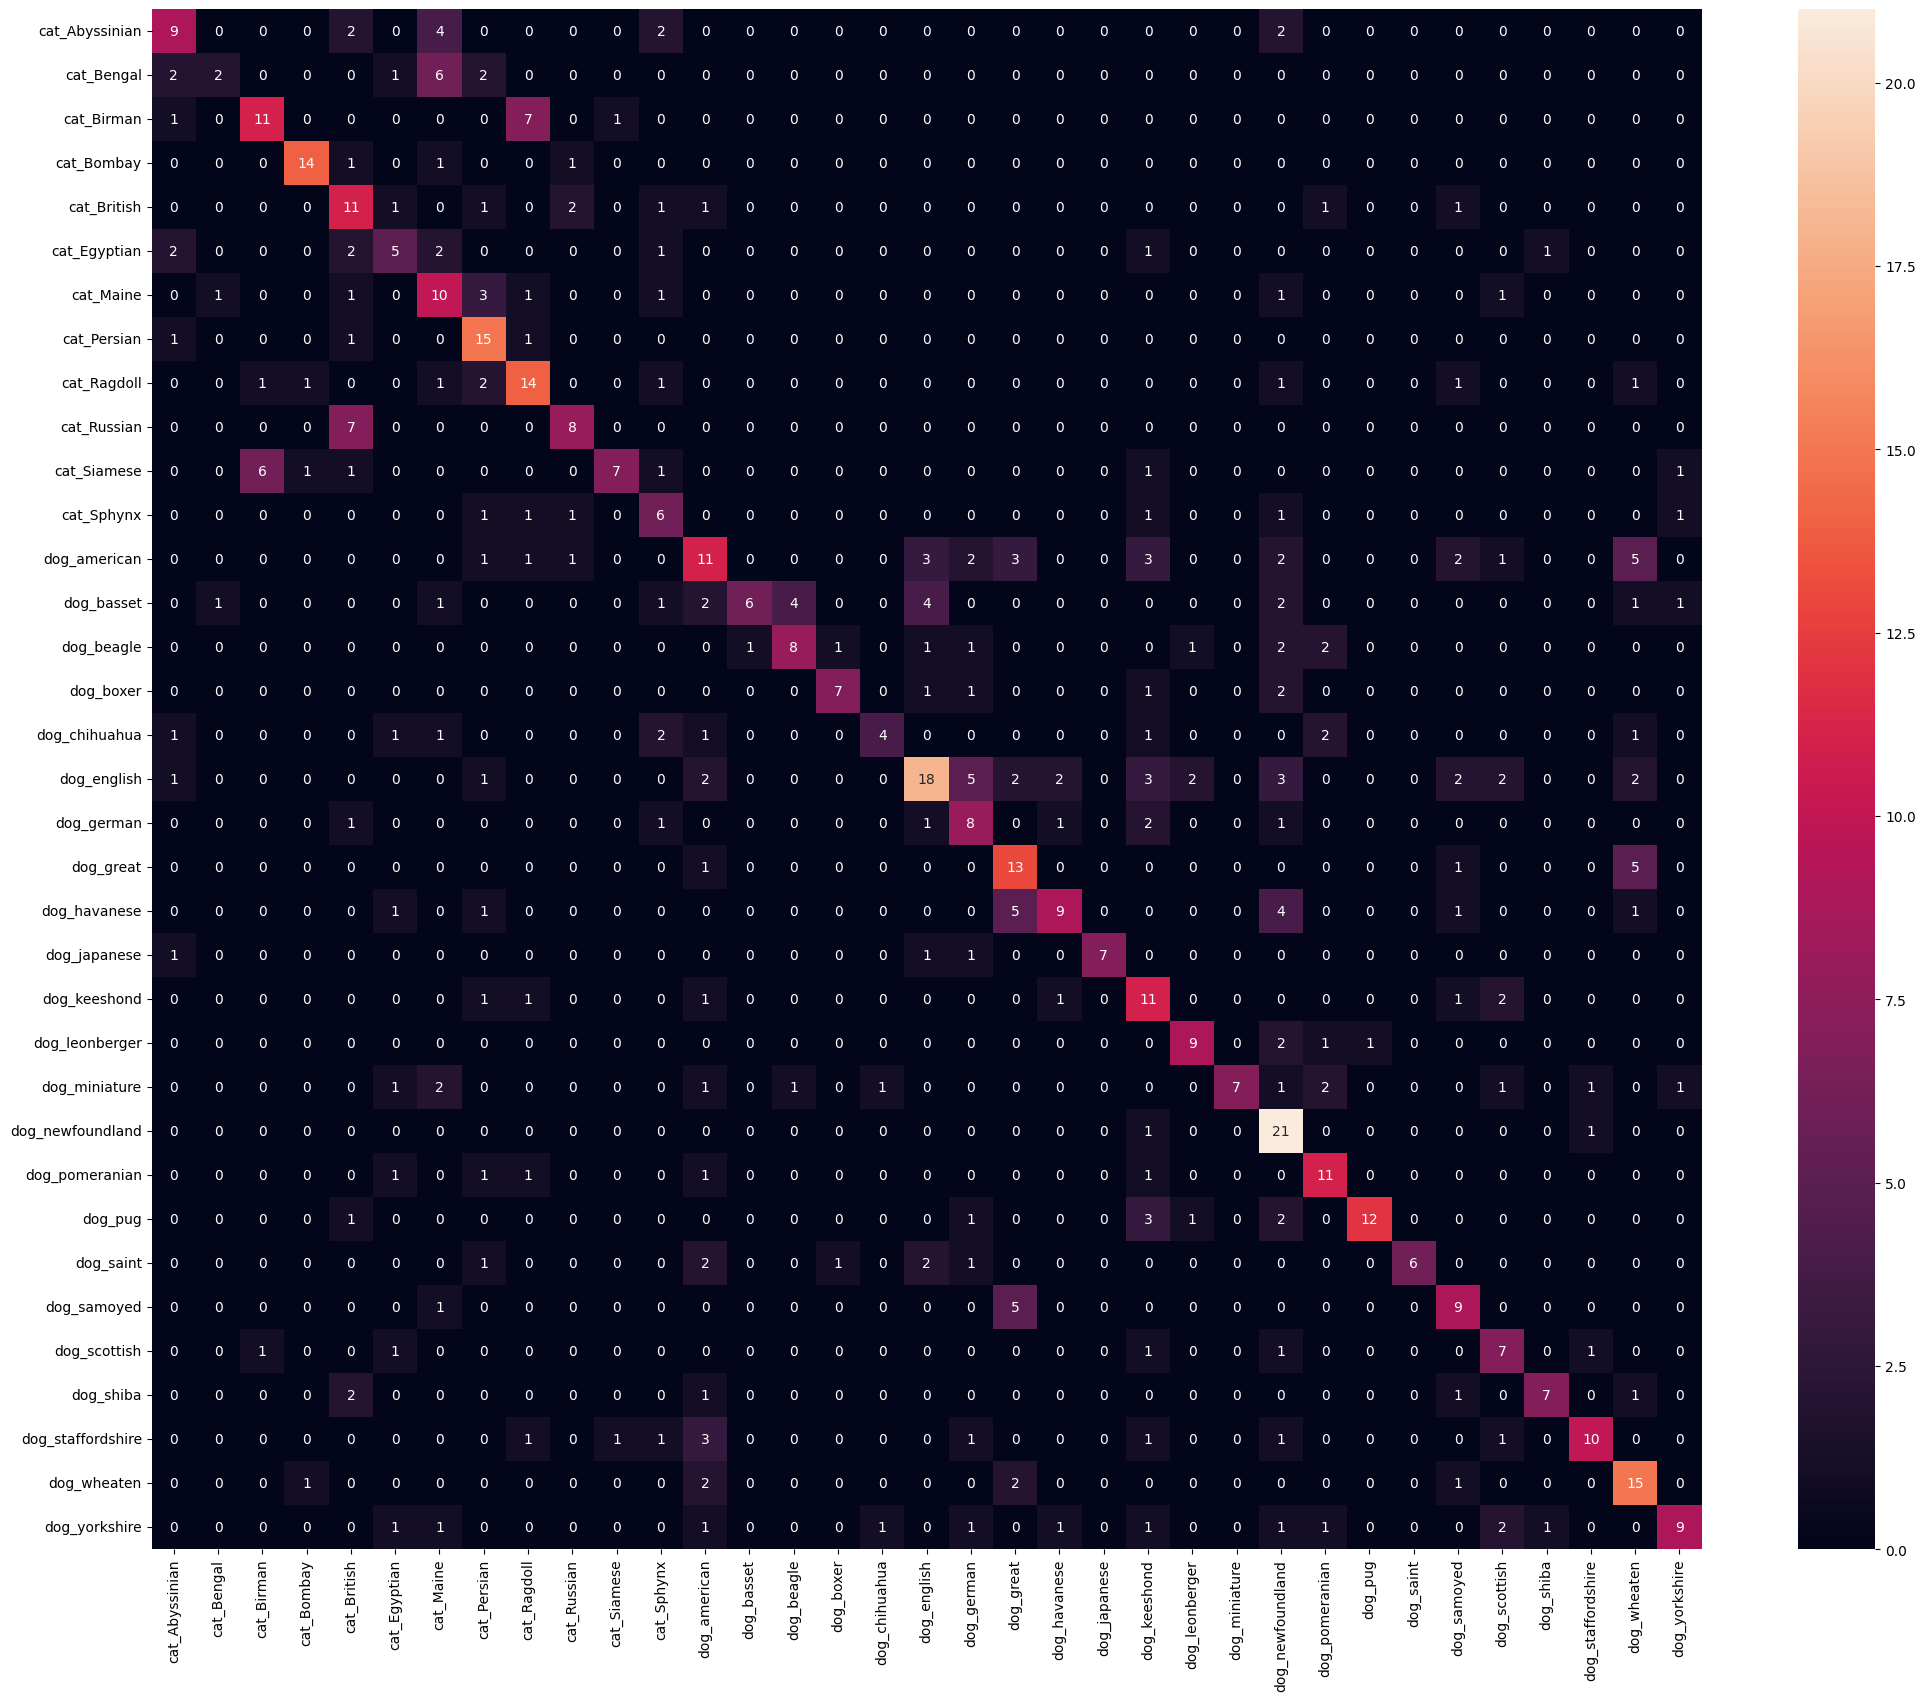

In [23]:
show_confusion_matrix(model, test_loader)

#### Top-3 Accuracy

In [24]:
correct = 0
total = 0
for t,l in test_loader:
    out = model(t.to(device))
    _,r = out.topk(3,1,True,True)
    r = r.t()
    correct += r.eq(l.to(device).view(1,-1).expand_as(r)).sum()
    total += len(l)
print(correct/total)

tensor(0.7387, device='cuda:0')


#### Подсчёт точности двоичной классификации "кошки против собак" на тестовом датасете

In [25]:
dataset = torchvision.datasets.ImageFolder(
    'petfaces',
    transform = tr.Compose([
        tr.Resize(image_size),
        tr.CenterCrop(image_size),
        tr.ToTensor()
    ]),
    target_transform = tr.Lambda(lambda pet_class: torch.tensor(1) if pet_classes_names[pet_class].startswith('cat_') else torch.tensor(0))
)

len_dataset = len(dataset)
train_length = int(0.8 * len_dataset)

train_data, test_data = torch.utils.data.random_split(dataset, [train_length, len_dataset-train_length])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

In [26]:
binary_model = torch.nn.Sequential(
    torch.nn.Conv2d(3,16,(3,3)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(16,32,(3,3)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(32,64,(3,3)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Flatten(),
    torch.nn.Linear(12544,2048),
    torch.nn.ReLU(),    
    torch.nn.Linear(2048,2)
).to(device)

history = train(binary_model,train_loader,test_loader,epochs=10,lr=0.001,loss_fn=torch.nn.CrossEntropyLoss())

Epoch  0: Train accuracy=0.630 | Val accuracy=0.692 | Train loss=0.011 | Val loss=0.010
Epoch  1: Train accuracy=0.758 | Val accuracy=0.844 | Train loss=0.008 | Val loss=0.006
Epoch  2: Train accuracy=0.862 | Val accuracy=0.844 | Train loss=0.005 | Val loss=0.006
Epoch  3: Train accuracy=0.900 | Val accuracy=0.768 | Train loss=0.004 | Val loss=0.009
Epoch  4: Train accuracy=0.913 | Val accuracy=0.854 | Train loss=0.003 | Val loss=0.006
Epoch  5: Train accuracy=0.936 | Val accuracy=0.904 | Train loss=0.003 | Val loss=0.005
Epoch  6: Train accuracy=0.948 | Val accuracy=0.908 | Train loss=0.002 | Val loss=0.004
Epoch  7: Train accuracy=0.965 | Val accuracy=0.927 | Train loss=0.001 | Val loss=0.004
Epoch  8: Train accuracy=0.979 | Val accuracy=0.914 | Train loss=0.001 | Val loss=0.006
Epoch  9: Train accuracy=0.982 | Val accuracy=0.913 | Train loss=0.001 | Val loss=0.012


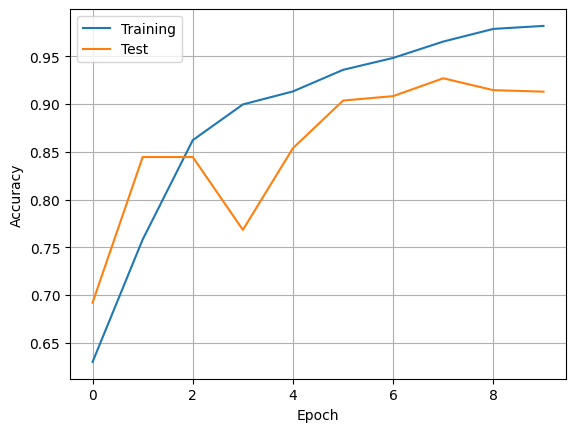

In [27]:
plt.plot(history['train_acc'],label='Training')
plt.plot(history['val_acc'],label='Test')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [30]:
def binary_confusion_matrix(net, test_loader):
  y_pred = []
  y_true = []

  # Проходим по тестовым данным

  for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          output = net(inputs)

          output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
          y_pred.extend(output)
          
          labels = labels.data.cpu().numpy()
          y_true.extend(labels)

  classes = ['cat', 'dog']

  conf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(conf_matrix, index = [i for i in classes],
                      columns = [i for i in classes])
  plt.figure(figsize = (8,8))
  sn.heatmap(df_cm, annot=True)

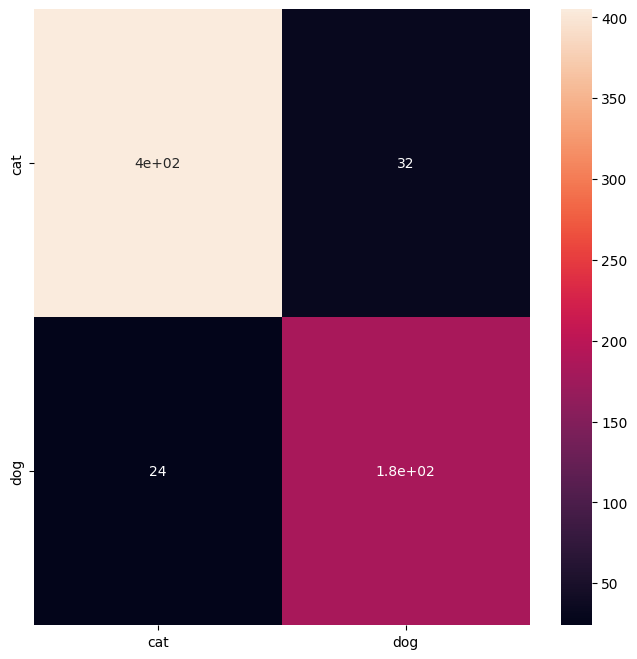

In [31]:
binary_confusion_matrix(binary_model, test_loader)